In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt

# Problem 1

In [2]:
x = np.array([0,4/5,1,2,3, 16/5,4,5,6])
P1 = np.concatenate( (x[:4] * 5 / 36, x[4:-2] * (-5) / 36 + 5/9, x[-2:] * 0), axis=0 )
P2 = np.array([1/9 for i in range(x.shape[0])])

<Figure size 432x288 with 0 Axes>

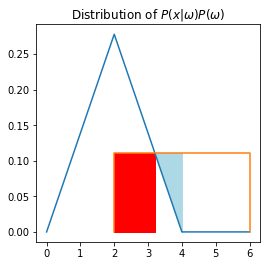

In [3]:
plt.clf()

plt.figure(figsize=(4,4))

plt.plot(x, P1)
plt.plot(np.concatenate((np.array([2]), x[3:], np.array([6]))), np.concatenate((np.array([0]),P2[3:], np.array([0]))))

plt.fill_between(x[5:7], P1[5:7], P2[5:7], color='lightblue')
plt.fill_between(x[3:6], 0, P2[3:6], color='red')

plt.xticks(list(range(7)))
plt.title(r"Distribution of $P(x|\omega)P(\omega)$")
plt.show()

$
\begin{equation*}
P(x|\omega_{1}) = \begin{cases}
    \frac{1}{4}x & \text{x } \in \text{[0, 2)} \\
    \frac{-1}{4}x+1 & \text{x } \in \text{[2, 4]}
    \end{cases}
\end{equation*} \\
P(x|\omega_{2}) = \frac{1}{4} \quad \text{x } \in \text{(2, 6)}$

$
\text{Since }P(\omega_{2})=\frac{4}{9} \Rightarrow P(\omega_{1})=\frac{5}{9}\\
\Rightarrow\begin{equation*}
\begin{cases}
    P(x|\omega_{1})P(\omega_{1}) = \begin{cases}
        \frac{5}{36}x & \text{x } \in \text{[0,2)} \\
        \frac{-5}{36}x+\frac{5}{9} & \text{x } \in \text{[2,4]}
        \end{cases} \\
    P(x|\omega_{2})P(\omega_{2}) = \frac{1}{9} \quad \text{x } \in \text{(2, 6)}
\end{cases}
\end{equation*} \quad \quad \text{Intersection: }( \frac{4}{5}, \frac{1}{9}),\quad( \frac{16}{5}, \frac{1}{9})$

### R1: the lightblue area
$Area=\frac{1}{2}*\frac{1}{9}*(4-\frac{16}{5})=\frac{2}{45}$
### R2: the red area
$Area=(\frac{16}{5}-2) * \frac{1}{9}=\frac{6}{45} \\
\Rightarrow P_e=\frac{2}{45}+\frac{6}{45}=\frac{8}{45}
$

# Problem 2

In [4]:
data_dir = "./p2_data/"

In [5]:
train_set = {}
test_set = {}

for f in os.listdir(data_dir):
    img = cv2.imread(data_dir + f, cv2.IMREAD_GRAYSCALE)
    
    f1 = int(f.strip(".png").split('_')[0])
    f2 = int(f.strip(".png").split('_')[1])
    
    if f2 <= 6:
        if f1 not in train_set:
            train_set[f1] = {}
        train_set[f1][f2] = img.copy()
    else:
        if f1 not in test_set:
            test_set[f1] = {}
        test_set[f1][f2] = img.copy()

In [6]:
for f1 in train_set:
    train_set[f1] = { f2:train_set[f1][f2] for f2 in sorted(list(train_set[f1].keys())) }

train_set = { f1:train_set[f1] for f1 in sorted(list(train_set.keys())) }

for f1 in test_set:
    test_set[f1] = { f2:test_set[f1][f2] for f2 in sorted(list(test_set[f1].keys())) }

test_set = { f1:test_set[f1] for f1 in sorted(list(test_set.keys())) }

## Q1

In [7]:
img_shape = (56, 46)
comp_num = 239

In [8]:
Q1_X = np.stack([ train_set[f1][f2] for f1 in train_set for f2 in train_set[f1] ]).reshape(-1, img_shape[0] * img_shape[1])
pca = PCA(n_components=comp_num)
Q1_X_a = pca.fit_transform(Q1_X)

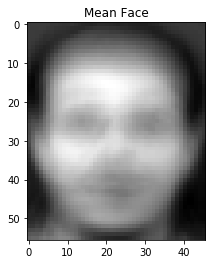

In [9]:
mean_face = pca.mean_.reshape(img_shape)
plt.clf()
plt.title("Mean Face")
plt.imshow(mean_face, cmap='gray')

<Figure size 432x288 with 0 Axes>

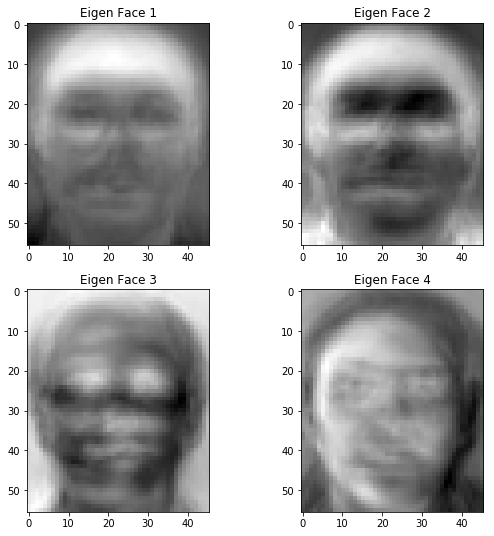

In [10]:
ef = pca.components_.reshape((comp_num, img_shape[0], img_shape[1]))

plt.clf()
rows = 2
columns = 2
fig=plt.figure(figsize=(4.5*rows, 4.5*columns))
gs = fig.add_gridspec(rows, columns)

for i in range(rows):
    for j in range(columns):
        img = ef[2*i+j]
        ax = fig.add_subplot(gs[i,j])
        ax.imshow(img, cmap='gray')
        ax.set_title("Eigen Face "+str(2*i+j+1))
plt.show()

## Q2, Q3

<Figure size 432x288 with 0 Axes>

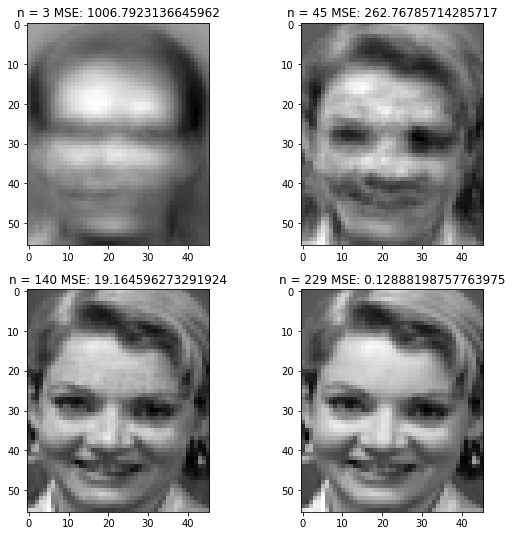

In [11]:
def eigen_face(mean, ef, pca_val, n):
    return mean + np.matmul( pca_val.transpose()[:,:n], ef[:n] ).squeeze().reshape(mean.shape)  

n = [3, 45, 140, 229]

plt.clf()
rows = 2
columns = 2
fig=plt.figure(figsize=(4.5*rows, 4.5*columns))
gs = fig.add_gridspec(rows, columns)

for i in range(rows):
    for j in range(columns):
        img = eigen_face(pca.mean_.reshape(img_shape), ef.reshape(comp_num, -1), Q1_X_a[0].reshape(-1,1), n[2*i+j]).round()
        ax = fig.add_subplot(gs[i,j])
        ax.imshow(img, cmap='gray')
        ax.set_title("n = "+str(n[2*i+j])+" MSE: "+ str(((img.flatten() - Q1_X[0])**2).mean()))
plt.show()

## Q4

### I use the mean of testing accuracy of each fold as the metric to determine which k and n is the best

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

In [13]:
all_k = [1, 3, 5]
all_n = [3, 45, 140]

In [14]:
train_X = Q1_X_a.copy()
train_Y = np.stack([ k for k in train_set.keys() for j in range(len(train_set[k]))])

In [15]:
best_k = -1
best_n = -1
best_ac = -1

for k in all_k:
    for n in all_n:
        
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        
        scores = cross_validate(knn, train_X[:,:n], train_Y, scoring="accuracy", n_jobs=-1, cv=3)
        mean_ac = scores["test_score"].mean()
        
        if mean_ac > best_ac:
            best_k = k
            best_n = n
            best_ac = mean_ac

In [16]:
print("3-Fold Cross Validation Result:")
print("Best Accuracy:", best_ac)
print("Best k:", best_k)
print("Best n:", best_n)

3-Fold Cross Validation Result:
Best Accuracy: 0.9291666666666667
Best k: 1
Best n: 140


## Q5

In [17]:
test_X = np.stack([ test_set[f1][f2] for f1 in test_set for f2 in test_set[f1] ]).reshape(-1, img_shape[0] * img_shape[1])
test_X = pca.transform(test_X)

test_Y = np.stack([ k for k in test_set.keys() for j in range(len(test_set[k]))])

In [18]:
knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn.fit(train_X[:,:best_n], train_Y)
test_ac = knn.score(test_X[:,:best_n], test_Y)
print("Test accuracy:", test_ac)

Test accuracy: 0.9375


# Problem 3

In [19]:
data_dir = "./p3_data/"
catagory_dir = os.listdir(data_dir)
catagory_dir

['banana', 'fountain', 'reef', 'tractor']

In [20]:
train_data = []
test_data = []

for cd in catagory_dir:
    
    all_img_fn = sorted(os.listdir(data_dir + cd), key=lambda x:int(x[x.index('_')+1:x.index('.')]))
    
    for fn in all_img_fn:
        
        img = cv2.imread(data_dir + cd + '/' + fn, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        
        if int(fn[fn.index('_')+1:fn.index('.')]) <= 375:
            train_data.append(img)
        else:
            test_data.append(img)

In [21]:
train_data = np.stack(train_data)
test_data = np.stack(test_data)

## Q1

In [22]:
def PatchImg(imgs):
    patches = []
    for idx in range(imgs.shape[0]):
        ps = []
        for i in range(4):
            for j in range(4):
                img = imgs[idx, i*16:(i+1)*16, j*16:(j+1)*16, :]
                ps.append(img)
        patches.append(ps)
    return patches

train_patches = PatchImg(train_data)
test_patches = PatchImg(test_data) 

### Each row for each category of images

<Figure size 432x288 with 0 Axes>

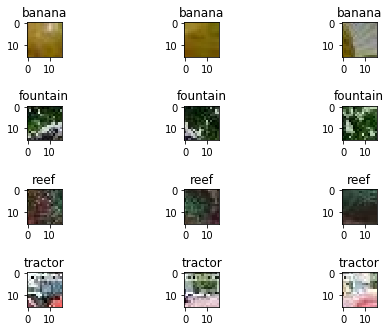

In [23]:
select_img = [ train_patches[(i*375)+5] for i in range(len(catagory_dir)) ]

plt.clf()
rows = 8
columns = 3
fig=plt.figure(figsize=(rows, 2*columns))
gs = fig.add_gridspec(rows, columns)

for i in range(rows//2):
    for j in range(columns):
        img = select_img[i][j]
        ax = fig.add_subplot(gs[2*i,j])
        ax.set_title(catagory_dir[i])
        ax.imshow(img)
plt.show()

### Q1: Describe whether you are able to classify an image by seeing just a few patches and write why.
### Answer: I can barely tell that the first row is banana because their color is yellow. However, I cannot tell what categories that the other 3 images belong to.

## Q2

In [24]:
train_patches = np.stack(train_patches)
test_patches = np.stack(test_patches)

In [25]:
train_patches = train_patches.reshape(train_patches.shape[0], train_patches.shape[1], -1)
train_patches = train_patches.reshape(train_patches.shape[0]*train_patches.shape[1], -1)

test_patches = test_patches.reshape(test_patches.shape[0], test_patches.shape[1], -1)
test_patches = test_patches.reshape(test_patches.shape[0]*test_patches.shape[1], -1)

In [26]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=15, max_iter=5000, n_jobs=-1)
train_cluster = kmean.fit_predict(train_patches)

In [27]:
pca = PCA(n_components=3)
pca.fit(train_patches)
train_patches_pca = pca.transform(train_patches)

In [28]:
select_idx = [0,3,7,10,12,13]
select_cluster = kmean.cluster_centers_[select_idx]
select_cluster_pca = pca.transform(select_cluster)

Black points indicate the centroid of each cluster


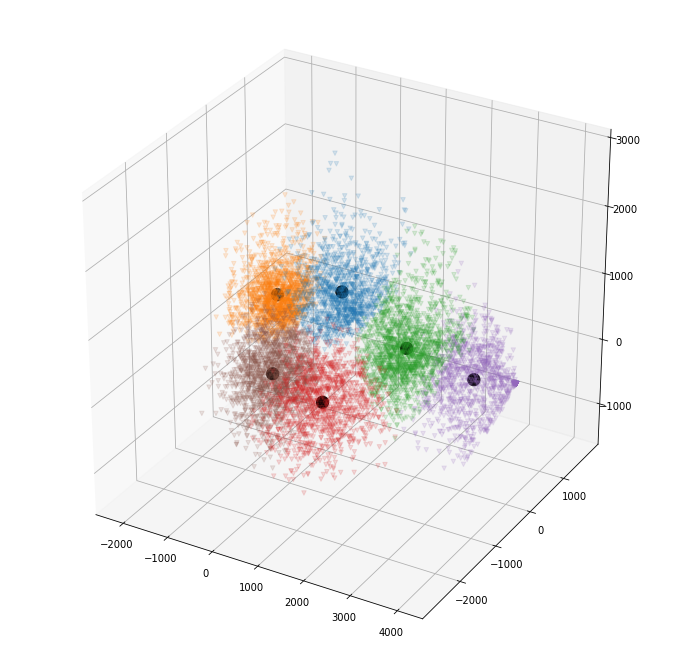

In [29]:
from mpl_toolkits.mplot3d import Axes3D

print("Black points indicate the centroid of each cluster")
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

for i in select_idx:
    data = train_patches_pca[np.where(train_cluster == i)[0],:]
    ax.scatter(data[:,0], data[:,1], data[:,2], alpha=0.15, marker='v')
    
ax.scatter(select_cluster_pca[:,0], select_cluster_pca[:,1], select_cluster_pca[:,2], s=150, alpha=1, color='black')
plt.show()

## Q3

In [30]:
def EucliDist(a,b):
    return np.sqrt(((a-b)**2).sum())

train_X = train_patches.reshape(train_data.shape[0],-1,16*16*3)
train_bow = []
for i in range(train_X.shape[0]):
    data = train_X[i]
    table = np.zeros((16,15))
    for j in range(data.shape[0]):
        for cidx in range(kmean.cluster_centers_.shape[0]):
            dist = EucliDist(data[j], kmean.cluster_centers_[cidx])
            table[j,cidx] = dist
        table[j] = ((1/table[j]) / (1/table[j]).sum())
    bow = table.max(axis=0)
    train_bow.append(bow)
select_bow = [ train_bow[(i*375)+5] for i in range(len(catagory_dir)) ]

<Figure size 432x288 with 0 Axes>

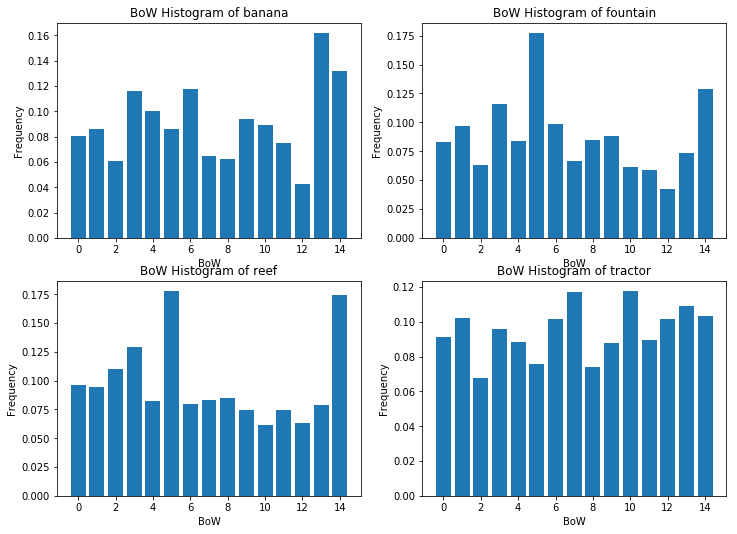

In [31]:
plt.clf()
rows, columns = 2, 2
fig=plt.figure(figsize=(6*rows, 4.35*columns))
gs = fig.add_gridspec(rows, columns)
for i in range(rows):
    for j in range(columns):
        ax = fig.add_subplot(gs[i,j])
        ax.bar( range(select_bow[2*i+j].shape[0]), select_bow[2*i+j])
        ax.set_title("BoW Histogram of "+catagory_dir[2*i+j])
        ax.set_xlabel("BoW")
        ax.set_ylabel("Frequency")

## Q4

In [32]:
test_X = test_patches.reshape(test_data.shape[0],-1,16*16*3)
test_bow = []

for i in range(test_X.shape[0]):
    data = test_X[i]
    table = np.zeros((16,15))
    for j in range(data.shape[0]):
        
        for cidx in range(kmean.cluster_centers_.shape[0]):
            dist = EucliDist(data[j], kmean.cluster_centers_[cidx])
            table[j,cidx] = dist
            
        table[j] = ((1/table[j]) / (1/table[j]).sum())
    
    bow = table.max(axis=0)
    test_bow.append(bow)

In [33]:
train_bow = np.stack(train_bow)
test_bow = np.stack(test_bow)

train_Y = np.array([ i for i in range(len(catagory_dir)) for j in range(375) ])
test_Y = np.array([ i for i in range(len(catagory_dir)) for j in range(125) ])

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf.fit(train_bow, train_Y)

pred = knn_clf.predict(test_bow)
ac = (pred == test_Y).sum() / test_Y.shape[0]
print("Accuracy:",ac)

Accuracy: 0.528
